## 1. Introduction
#### In this notebook, we explore the PM2.5 dataset using a combination of summary statistics and residual-based methods to detect anomalies and better understand the distribution of air pollution levels across various countries and demographic groups. This comprehensive approach helps uncover hidden patterns and identify data points that deviate significantly from expected trends.

In [70]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [71]:
# Import the dataset
df = pd.read_csv("../data/processed/pm25_cleaned.csv")

In [72]:
# drop useless columns
df = df.drop(columns=["Period type", "Dim1 type", "Location type", "Dim1ValueCode", "IndicatorCode", "Indicator", "ParentLocationCode", "ValueType"])
df.head()

,ParentLocation,SpatialDimValueCode,Location,Period,IsLatestYear,Dim1,FactValueNumeric,FactValueNumericLow,FactValueNumericHigh,Value,Language,DateModified,FactValueNumericSpread
0,Africa,KEN,Kenya,2019,True,Cities,10.01,6.29,13.74,10.01 [6.29-13.74],EN,2022-08-12 05:00:00+00:00,7.45
1,Americas,TTO,Trinidad and Tobago,2019,True,Rural,10.02,7.44,12.55,10.02 [7.44-12.55],EN,2022-08-12 05:00:00+00:00,5.11
2,Europe,GBR,United Kingdom of Great Britain and Northern I...,2019,True,Cities,10.06,9.73,10.39,10.06 [9.73-10.39],EN,2022-08-12 05:00:00+00:00,0.66
3,Americas,GRD,Grenada,2019,True,Total,10.08,7.07,13.20,10.08 [7.07-13.20],EN,2022-08-12 05:00:00+00:00,6.13
4,Americas,BRA,Brazil,2019,True,Towns,10.09,8.23,12.46,10.09 [8.23-12.46],EN,2022-08-12 05:00:00+00:00,4.23


## 2. Summary Statistics
#### To build a foundational understanding of the data, we performed a series of summary statistical analyses focusing on the FactValueNumeric variable, which represents PM2.5 levels. This included:

- #### Descriptive Statistics: Calculation of central tendency and dispersion metrics such as the mean, median, standard deviation, minimum, and maximum PM2.5 values.
- #### Distribution Analysis: Examination of PM2.5 levels across different geographic and demographic dimensions to determine which regions or categories consistently exhibit high or low pollution levels.

In [73]:
# Summary stats for all PM2.5 values
df['FactValueNumeric'].describe()

count    9169.000000
mean       22.229568
std        13.174273
min         4.590000
25%        11.660000
50%        19.050000
75%        29.260000
max        59.560000
Name: FactValueNumeric, dtype: float64

In [74]:
# Summary stats for PM2.5 values by country
print("Summary statistics for PM2.5 values by country:")
df.groupby('Location')['FactValueNumeric'].describe().reset_index()

Summary statistics for PM2.5 values by country:


,Location,count,mean,std,min,25%,50%,75%,max
0,Afghanistan,3.0,56.026667,0.960278,55.08,55.5400,56.000,56.5000,57.00
1,Albania,50.0,19.846000,1.949844,15.65,18.6950,19.405,21.6200,23.41
2,Algeria,50.0,22.340200,0.940253,20.20,21.6725,22.490,22.9600,24.13
3,Andorra,40.0,9.964250,1.108168,7.96,9.2250,9.710,10.6075,12.13
4,Angola,50.0,26.599400,2.888965,22.37,24.2325,26.305,28.4050,33.19
...,...,...,...,...,...,...,...,...,...
190,Viet Nam,50.0,21.244400,2.125945,16.97,20.1050,21.470,22.6125,25.18
191,Yemen,50.0,41.192800,1.747645,37.00,40.0125,41.285,42.4875,44.60
192,Zambia,50.0,18.006600,1.229355,16.10,17.0150,17.575,19.2475,20.07
193,Zimbabwe,50.0,13.682800,0.986534,12.34,13.0925,13.270,14.6375,15.19


In [75]:
# Summary stats for PM2.5 values by year
print("Summary statistics for PM2.5 values by year:")
df.groupby('Period')['FactValueNumeric'].describe().reset_index()

Summary statistics for PM2.5 values by year:


,Period,count,mean,std,min,25%,50%,75%,max
0,2010,919.0,22.790185,12.803598,4.65,12.765,20.52,29.865,58.95
1,2011,917.0,22.958724,13.278298,4.59,12.760,20.44,29.790,59.45
2,2012,913.0,22.659956,13.415207,4.93,12.120,19.62,29.180,59.56
3,2013,908.0,22.150319,12.819510,4.75,11.850,19.49,29.220,59.05
4,2014,919.0,22.166714,13.108096,4.98,11.640,19.12,29.335,59.30
5,2015,911.0,22.286257,13.354054,4.97,11.645,18.87,29.065,59.52
6,2016,919.0,22.220740,13.435855,4.93,11.100,18.67,29.565,59.20
7,2017,919.0,21.941458,13.260445,4.94,11.335,18.42,28.660,59.39
8,2018,919.0,21.868052,13.230443,5.13,10.935,18.47,29.010,59.51
9,2019,925.0,21.263524,13.000583,4.86,10.510,17.19,28.400,59.53


In [76]:
# Summary stats for PM2.5 values by country and year
print("Summary statistics for PM2.5 values by country and year:")
df.groupby(['Location', 'Period'])['FactValueNumeric'].describe().reset_index()

Summary statistics for PM2.5 values by country and year:


,Location,Period,count,mean,std,min,25%,50%,75%,max
0,Afghanistan,2016,1.0,57.000,NaN,57.00,57.00,57.00,57.00,57.00
1,Afghanistan,2017,1.0,55.080,NaN,55.08,55.08,55.08,55.08,55.08
2,Afghanistan,2019,1.0,56.000,NaN,56.00,56.00,56.00,56.00,56.00
3,Albania,2010,5.0,22.048,0.406165,21.38,21.95,22.24,22.30,22.37
4,Albania,2011,5.0,23.104,0.459924,22.34,23.00,23.38,23.39,23.41
...,...,...,...,...,...,...,...,...,...,...
1931,"occupied Palestinian territory, including east...",2015,5.0,30.116,2.167759,27.79,28.17,30.49,31.10,33.03
1932,"occupied Palestinian territory, including east...",2016,5.0,29.910,2.217081,27.54,27.91,30.29,30.92,32.89
1933,"occupied Palestinian territory, including east...",2017,5.0,29.534,1.606885,27.76,28.14,29.81,30.28,31.68
1934,"occupied Palestinian territory, including east...",2018,5.0,30.206,1.779081,28.25,28.65,30.52,31.03,32.58


In [77]:
# Summary stats for all columns
df.describe(include='all')

# Check if Period column contains any NaN values
#print("Checking for NaN values in 'Period' column:")
#print(df['Period'].isna().sum())

,ParentLocation,SpatialDimValueCode,Location,Period,IsLatestYear,Dim1,FactValueNumeric,FactValueNumericLow,FactValueNumericHigh,Value,Language,DateModified,FactValueNumericSpread
count,9169,9169,9169,9169.000000,9169,9169,9169.000000,9169.000000,9169.000000,9169,9169,9169,9169.000000
unique,6,195,195,NaN,2,5,NaN,NaN,NaN,8887,1,1,NaN
top,Europe,KEN,Kenya,NaN,False,Rural,NaN,NaN,NaN,12.37 [11.00-13.76],EN,2022-08-12 05:00:00+00:00,NaN
freq,2556,50,50,NaN,8244,1916,NaN,NaN,NaN,3,9169,9169,NaN
mean,NaN,NaN,NaN,2014.506707,NaN,NaN,22.229568,15.256668,33.802624,NaN,NaN,NaN,18.545956
std,NaN,NaN,NaN,2.876339,NaN,NaN,13.174273,9.724347,25.652909,NaN,NaN,NaN,22.983573
min,NaN,NaN,NaN,2010.000000,NaN,NaN,4.590000,1.410000,5.260000,NaN,NaN,NaN,0.190000
25%,NaN,NaN,NaN,2012.000000,NaN,NaN,11.660000,7.760000,15.710000,NaN,NaN,NaN,3.990000
50%,NaN,NaN,NaN,2015.000000,NaN,NaN,19.050000,13.310000,23.850000,NaN,NaN,NaN,10.170000
75%,NaN,NaN,NaN,2017.000000,NaN,NaN,29.260000,19.570000,46.720000,NaN,NaN,NaN,23.530000


In [78]:
# Summary by year
year_summary = df.groupby('Period')['FactValueNumeric'].agg(['mean', 'median', 'min', 'max', 'std']).round(2)
year_summary

# Summary by Parent Location and Year
parent_location_year_summary = df.groupby(['ParentLocation', 'Period'])['FactValueNumeric'].agg(['mean', 'median', 'min', 'max', 'std']).round(2).reset_index()

In [79]:
# Summary by country
country_summary = df.groupby('Location')['FactValueNumeric'].agg(['mean', 'median', 'min', 'max', 'std']).round(2)

# Summary by year
year_summary = df.groupby('Period')['FactValueNumeric'].agg(['mean', 'median', 'min', 'max', 'std']).round(2)

# Summary by Parent Location
parent_summary = df.groupby('ParentLocation')['FactValueNumeric'].agg(['mean', 'median', 'min', 'max', 'std']).round(2)


In [80]:
# Top 10 most polluted countries
top10_polluted = country_summary.sort_values(by='mean', ascending=False).head(10)
top10_polluted

,mean,median,min,max,std
Location,,,,,
Kuwait,56.87,56.72,52.82,59.02,1.60
Qatar,56.55,56.50,51.92,59.30,2.06
Saudi Arabia,56.48,56.69,51.98,58.60,1.63
Cameroon,56.22,57.01,50.83,59.56,2.55
Tajikistan,56.20,56.38,50.58,59.39,2.91
Afghanistan,56.03,56.00,55.08,57.00,0.96
Pakistan,55.26,55.82,48.52,59.51,2.72
Nigeria,55.04,55.10,51.15,58.56,1.96
Bahrain,54.22,54.40,49.32,59.45,2.34


In [81]:
# Years In Descending Order of Pollution
years_desc_pollution = year_summary.sort_values(by='mean', ascending=False).head(10)
years_desc_pollution

,mean,median,min,max,std
Period,,,,,
2011,22.96,20.44,4.59,59.45,13.28
2010,22.79,20.52,4.65,58.95,12.80
2012,22.66,19.62,4.93,59.56,13.42
2015,22.29,18.87,4.97,59.52,13.35
2016,22.22,18.67,4.93,59.20,13.44
2014,22.17,19.12,4.98,59.30,13.11
2013,22.15,19.49,4.75,59.05,12.82
2017,21.94,18.42,4.94,59.39,13.26
2018,21.87,18.47,5.13,59.51,13.23


In [82]:
# Top 10 cleanest countries
bottom10_polluted = country_summary.sort_values(by='mean', ascending=True).head(10)
bottom10_polluted

,mean,median,min,max,std
Location,,,,,
Bahamas,5.30,5.28,4.59,6.17,0.35
Finland,6.49,6.40,4.93,8.74,0.97
Niue,6.55,6.52,6.34,6.75,0.15
Iceland,6.58,6.46,5.47,8.49,0.71
Sweden,6.70,6.62,5.24,8.89,0.88
Tuvalu,6.84,6.83,6.70,6.95,0.08
Nauru,6.93,7.37,5.32,7.59,0.85
Canada,7.04,7.12,5.06,8.57,0.87
Estonia,7.14,7.02,5.40,8.89,0.88


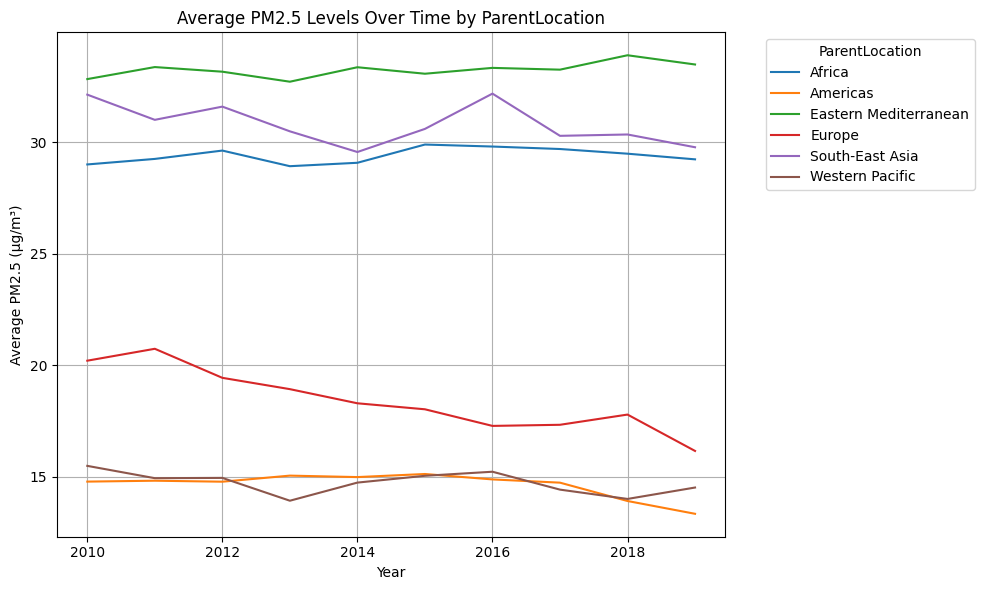

In [83]:
# Parent Locations In Descending Order of Pollution
parent_desc_pollution = parent_summary.sort_values(by='mean', ascending=False).head(10)
parent_desc_pollution

# Create a pivot table
summary_table = df.pivot_table(
    index='ParentLocation',  # Rows: ParentLocation
    columns='Period',        # Columns: Period (year)
    values='FactValueNumeric',  # Values: Average FactValueNumeric
    aggfunc='mean'           # Aggregation function: mean
)

# Display the summary table
summary_table

# Plot the pivot table
summary_table.T.plot(figsize=(10, 6))  # Transpose to make years the x-axis
plt.title('Average PM2.5 Levels Over Time by ParentLocation')
plt.xlabel('Year')
plt.ylabel('Average PM2.5 (µg/m³)')
plt.legend(title='ParentLocation', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [84]:
# Summary by region
region_summary = df.groupby('ParentLocation')['FactValueNumeric'].agg(['mean', 'median', 'min', 'max', 'std']).round(2)
region_summary

,mean,median,min,max,std
ParentLocation,,,,,
Africa,29.40,29.05,9.77,59.56,12.46
Americas,14.65,12.84,4.59,34.66,6.57
Eastern Mediterranean,33.26,29.23,12.32,59.51,13.36
Europe,18.41,15.70,4.93,59.39,10.51
South-East Asia,30.81,26.17,11.68,59.07,13.47
Western Pacific,14.73,8.45,5.32,59.52,11.26


In [85]:
# Summary by area type 
area_summary = df.groupby('Dim1')['FactValueNumeric'].agg(['mean', 'median', 'min', 'max', 'std']).round(2)
area_summary

,mean,median,min,max,std
Dim1,,,,,
Cities,24.40,21.34,4.59,59.53,13.29
Rural,20.94,17.52,4.92,59.13,12.89
Total,21.63,18.47,4.92,59.39,12.95
Towns,21.91,18.49,5.22,59.45,13.09
Urban,22.58,19.12,4.92,59.56,13.44


In [86]:
guideline = 22  # mean guideline (µg/m³)

above_guideline = df[df['FactValueNumeric'] > guideline]
pct_above = len(above_guideline) / len(df) * 100

print("\nGuideline Benchmarking:")
print(f"- annual guideline: {guideline} µg/m³")
print(f"- Observations above guideline: {len(above_guideline)} ({pct_above:.1f}%)")
print(f"- Highest value: {df['FactValueNumeric'].max():.1f} µg/m³")
print(f"- Lowest value: {df['FactValueNumeric'].min():.1f} µg/m³")

# By region
print("\nPercentage above guideline by region:")
display(above_guideline.groupby('ParentLocation').size() / df.groupby('ParentLocation').size() * 100)


Guideline Benchmarking:
- annual guideline: 22 µg/m³
- Observations above guideline: 3835 (41.8%)
- Highest value: 59.6 µg/m³
- Lowest value: 4.6 µg/m³

Percentage above guideline by region:


ParentLocation
Africa                   65.815664
Americas                 16.508876
Eastern Mediterranean    82.814178
Europe                   26.017214
South-East Asia          68.918919
Western Pacific          20.808255
dtype: float64

## 3. Residual Analysis
#### To further investigate unusual patterns in the data, we fitted an Ordinary Least Squares (OLS) regression model using Location (Country) and Dim1 (urban, rural, total, etc.) as predictors of PM2.5 levels. Residuals—defined as the difference between actual and predicted PM2.5 values—were then analyzed to identify anomalous observations. This residual-based approach provides two key benefits:

- #### Detection of Irregularities: Residuals reveal data points that deviate significantly from the model’s expectations, indicating possible outliers.

- #### Contextual Insight: It highlights country- or category-specific deviations that may not be captured by global summary statistics alone.

#### Boxplots and IQR-based techniques were used to flag outliers in the residuals, offering a systematic way to identify unusual patterns and potential anomalies.

      Observed  Predicted
0        10.01  14.129449
1        10.02   8.584777
2        10.06  12.618649
3        10.08  10.184834
4        10.09  12.355829
...        ...        ...
9164      9.91  11.248624
9165      9.92  12.379049
9166      9.92  12.177249
9167      9.94  14.129449
9168      9.95  10.159249

[9169 rows x 2 columns]


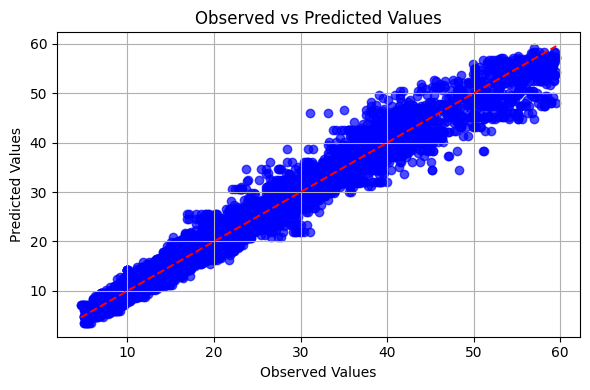

                            OLS Regression Results                            
Dep. Variable:       FactValueNumeric   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     1610.
Date:                Sun, 04 May 2025   Prob (F-statistic):               0.00
Time:                        19:30:27   Log-Likelihood:                -20155.
No. Observations:                9169   AIC:                         4.071e+04
Df Residuals:                    8970   BIC:                         4.212e+04
Df Model:                         198                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [87]:
# Step 1: One-hot encode categorical variables (and ensure dtype is float)
X = pd.get_dummies(df[['Dim1', 'Location']], drop_first=True).astype(float)
#print("Preview of one-hot encoded predictors:")
#print(X.head())

# Step 2: Define target variable
y = df['FactValueNumeric'].astype(float)

# Step 3: Add constant to the predictors
X = sm.add_constant(X)

# Step 4: Fit the linear regression model
model = sm.OLS(y, X).fit()

# Alternative: Quant Regression
from statsmodels.regression.quantile_regression import QuantReg
#model = QuantReg(y, X).fit(q=0.5)  # q=0.5 for median regression

# Extract fitted values (predicted y)
fitted_vals = model.fittedvalues

# Compare observed vs predicted
comparison = pd.DataFrame({'Observed': y, 'Predicted': fitted_vals})
print(comparison)

# Plot observed vs predicted
plt.figure(figsize=(6, 4))
plt.scatter(y, fitted_vals, color='blue', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # 45-degree line
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Observed vs Predicted Values')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 5: Print the summary of the model
print(model.summary())


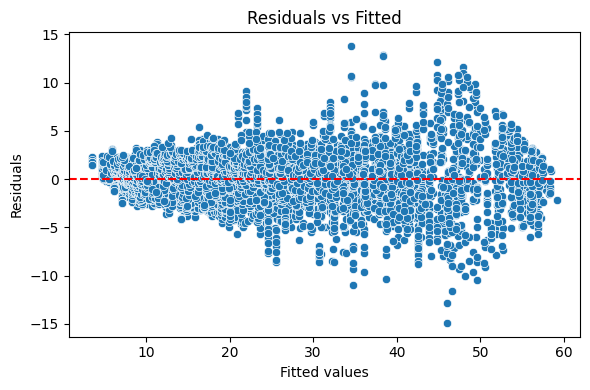

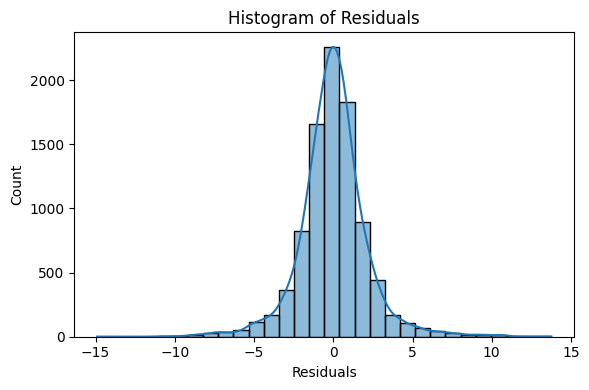

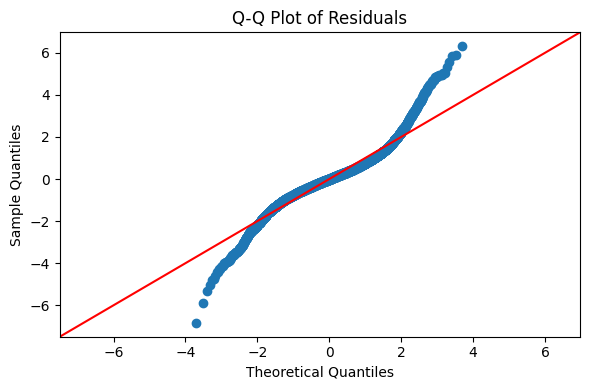

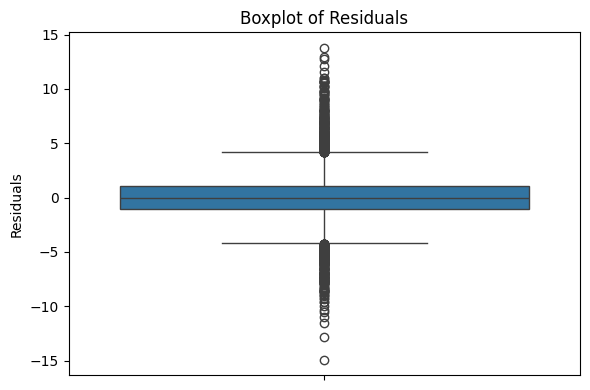

In [88]:
# Predicted values and residuals
fitted_vals = model.fittedvalues
residuals = model.resid

# 1. Residuals vs Fitted
plt.figure(figsize=(6, 4))
sns.scatterplot(x=fitted_vals, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.tight_layout()
plt.show()

# 2. Histogram of Residuals
plt.figure(figsize=(6, 4))
sns.histplot(residuals, kde=True, bins=30)
plt.xlabel('Residuals')
plt.title('Histogram of Residuals')
plt.tight_layout()
plt.show()

# 3. Q-Q Plot
fig, ax = plt.subplots(figsize=(6, 4))
sm.qqplot(residuals, line='45', fit=True, ax=ax)
plt.title('Q-Q Plot of Residuals')
plt.tight_layout()
plt.show()

# Boxplot of residuals
plt.figure(figsize=(6, 4))
sns.boxplot(y=residuals)
plt.title("Boxplot of Residuals")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

In [89]:
resid_df = pd.DataFrame({'Residuals': residuals})

# Calculate Q1, Q3, and IQR
Q1 = resid_df['Residuals'].quantile(0.25)
Q3 = resid_df['Residuals'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [90]:
outliers = resid_df[(resid_df['Residuals'] < lower_bound) | (resid_df['Residuals'] > upper_bound)]

# Display outliers
outliers

,Residuals
169,-4.543624
185,-4.937049
191,-5.675249
199,-4.476624
230,-4.255224
...,...
8968,-5.688849
8975,5.569758
8996,4.310103
9000,9.486084



New DataFrame with predictions for 2020:
      ParentLocation SpatialDimValueCode Location  Period IsLatestYear    Dim1  \
9169            NaN                 NaN    Kenya    2020          NaN  Cities   
9170            NaN                 NaN    Kenya    2020          NaN   Rural   
9171            NaN                 NaN    Kenya    2020          NaN   Total   

      FactValueNumeric  FactValueNumericLow  FactValueNumericHigh Value  \
9169         14.129449                  NaN                   NaN   NaN   
9170         10.536977                  NaN                   NaN   NaN   
9171         11.927722                  NaN                   NaN   NaN   

     Language DateModified  FactValueNumericSpread  
9169      NaN          NaN                     NaN  
9170      NaN          NaN                     NaN  
9171      NaN          NaN                     NaN  


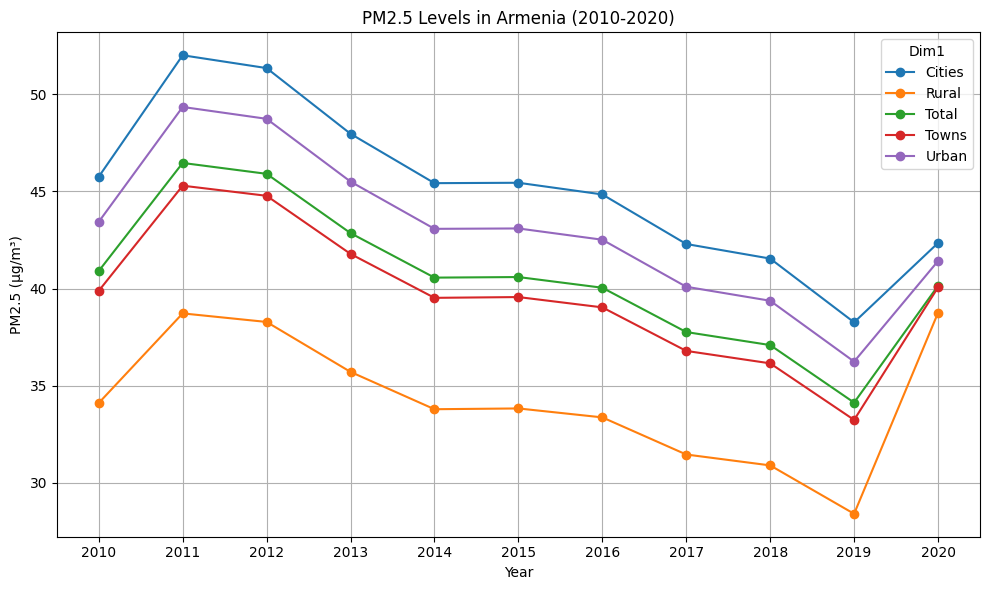

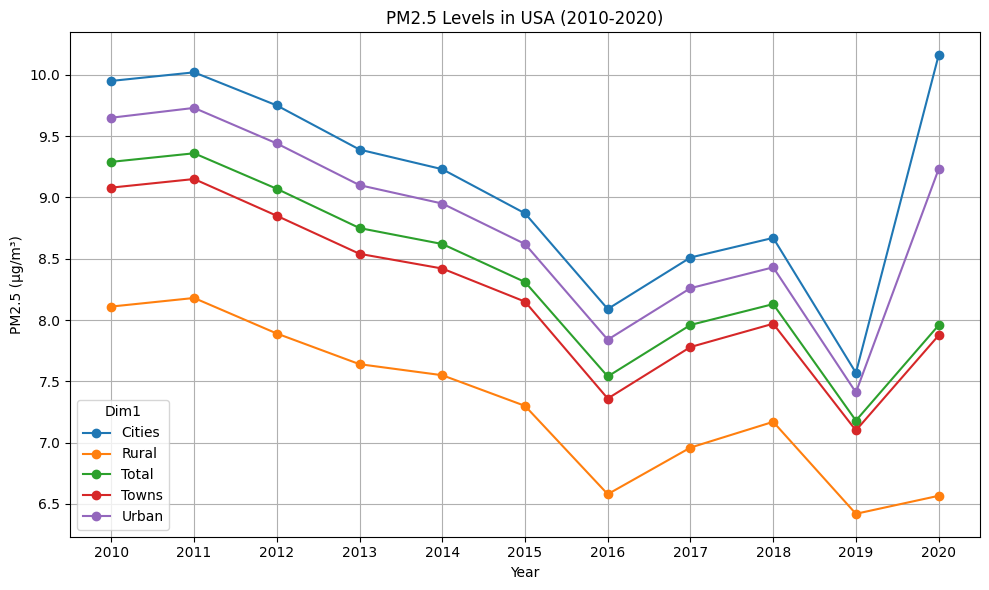

In [91]:
# Predicint PM2.5 in 2020
future_data = pd.DataFrame([
    {'Location': loc, 'Dim1': dim, 'Period': 2020}
    for loc in locations for dim in dim1_values
])
# One-hot encode the future data
future_data_encoded = pd.get_dummies(future_data[['Dim1', 'Location']], drop_first=True).astype(float)
# Add constant to the future data
future_data_encoded = sm.add_constant(future_data_encoded)
# Predict PM2.5 for 2020
predictions_2020 = model.predict(future_data_encoded)

# Add predicitons to existing DataFrame as new rows with Period 2020
future_data['FactValueNumeric'] = predictions_2020
# Append the predictions to the original DataFrame
df = pd.concat([df, future_data], ignore_index=True)
# Display the first few rows of the updated DataFrame
# filter for the year 2020
df_2020 = df[df['Period'] == 2020]
print("\nNew DataFrame with predictions for 2020:\n", df_2020.head(3))

# Plot PM2.5 from 2010 to 2020 for each Dim1 in Armenia
plt.figure(figsize=(10, 6))
for dim in df['Dim1'].unique():
    subset = df[(df['Location'] == 'Armenia') & (df['Dim1'] == dim)].sort_values(by='Period')
    plt.plot(subset['Period'], subset['FactValueNumeric'], marker='o', label=dim)
plt.title('PM2.5 Levels in Armenia (2010-2020)')
plt.xlabel('Year')
plt.ylabel('PM2.5 (µg/m³)')
plt.xticks(subset['Period'].unique())
plt.legend(title='Dim1')
plt.grid(True)
plt.tight_layout()
plt.show()

# Repeat for United States
plt.figure(figsize=(10, 6))
for dim in df['Dim1'].unique():
    subset = df[(df['Location'] == 'United States of America') & (df['Dim1'] == dim)].sort_values(by='Period')
    plt.plot(subset['Period'], subset['FactValueNumeric'], marker='o', label=dim)
plt.title('PM2.5 Levels in USA (2010-2020)')
plt.xlabel('Year')
plt.ylabel('PM2.5 (µg/m³)')
plt.xticks(subset['Period'].unique())
plt.legend(title='Dim1')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4. Conclusion
#### By combining summary statistics with residual analysis, this notebook provides a well-rounded examination of PM2.5 levels in from 2011-2019. OLS regression shows promise in predicting PM2.5 levels according to Location (Country) and Dim1 (whether a site is rural, urban, etc.) Predictions for 2020 were made with the OLS model, but indicate that the model can be improved due to broken trendlines in PM2.5 concentrations over the years. While summary statistics offer a high-level view of pollution distribution across dimensions, residual-based methods help uncover context-specific anomalies that merit further investigation. These insights can be valuable for:

- #### Environmental monitoring agencies seeking to target high-risk regions,

- #### Data scientists aiming to refine predictive models,

- #### and policy-makers focusing on health-related interventions.

#### This dual-method approach ensures a more robust and insightful understanding of air quality patterns and their implications.